In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 7.8 MB/s 
     |████████████████████████████████| 7.6 MB 50.4 MB/s 
     |████████████████████████████████| 163 kB 74.1 MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib
import seaborn
import sklearn
import torch

In [ ]:
from transformers import DistilBertTokenizerFast, BertTokenizer
from transformers import TFDistilBertForSequenceClassification, TFDistilBertForTokenClassification

In [ ]:
!python --version

Python 3.7.12


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/VaksinCov/train sars-cov-2 tw.csv')
df.head()

,tweet,sentiment,Unnamed: 2
0,@Namaku_Mei Secara pribadi saya mengakui mayor...,pos,NaN
1,Tangan Dokter yang Suntik Vaksin Covid-19 ke P...,netral,NaN
2,"Bakal Disuntik Vaksin Covid Perdana di Batam, ...",netral,NaN
3,@bebesushi @kopiganja Nope. Vitamin tdk berpen...,netral,NaN
4,@TrinityTraveler Padahal upaya untuk mencapai ...,neg,NaN


In [ ]:
df = df.drop('Unnamed: 2', 1)
df.head()

,tweet,sentiment
0,@Namaku_Mei Secara pribadi saya mengakui mayor...,pos
1,Tangan Dokter yang Suntik Vaksin Covid-19 ke P...,netral
2,"Bakal Disuntik Vaksin Covid Perdana di Batam, ...",netral
3,@bebesushi @kopiganja Nope. Vitamin tdk berpen...,netral
4,@TrinityTraveler Padahal upaya untuk mencapai ...,neg


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.stem import PorterStemmer
import string

def cleaned_text(text):
    text = text.lower()
    text = re.sub('@[A-Za-z0-9_]+','',text)
    text = re.sub('#\w+','',text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\d+', '', text)
    text = re.sub("\s+"," ",text).strip()
    return text

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = cleaned_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    ps = PorterStemmer()
    word_stemmer = [ps.stem(w) for w in tokenized_text]
    combined_text = ' '.join(word_stemmer)
    return combined_text     

df['tweet'] = df['tweet'].apply(lambda x : text_preprocessing(x))

df.head()

,tweet,sentiment
0,secara pribadi saya mengakui mayorita mereka p...,pos
1,tangan dokter yang suntik vaksin ke presiden j...,netral
2,bakal disuntik vaksin covid perdana di batam i...,netral
3,nope vitamin tdk berpengaruh dalam pembentukan...,netral
4,padah upaya untuk mencapai tawakk adalah ikhti...,neg


In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3793 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      3793 non-null   object
 1   sentiment  3793 non-null   object
dtypes: object(2)
memory usage: 88.9+ KB


In [ ]:
df.sentiment.unique()

array(['pos', 'netral', 'neg'], dtype=object)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

In [ ]:
X = df['tweet']
y= df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
tokenizer([X_train[0]], truncation=True,
                            padding=True,
           max_length=128)

{'input_ids': [[3, 1789, 3960, 1731, 4516, 8918, 1636, 1633, 1560, 10990, 17215, 4041, 1630, 12959, 1570, 1906, 2506, 1686, 28912, 1528, 1540, 2362, 6538, 2730, 2112, 5299, 2280, 1485, 1956, 1497, 3381, 5940, 2818, 9969, 7911, 2064, 11795, 4413, 1731, 12959, 1570, 10243, 4322, 6952, 933, 1570, 11198, 4]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
df['sentiment'] = df['sentiment'].replace('netral', 0)
df['sentiment'] = df['sentiment'].replace('pos', 1)
df['sentiment'] = df['sentiment'].replace('neg', 2)

In [ ]:
df['sentiment']

0       1
1       0
2       0
3       0
4       2
       ..
3793    1
3794    2
3795    1
3796    0
3797    0
Name: sentiment, Length: 3793, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


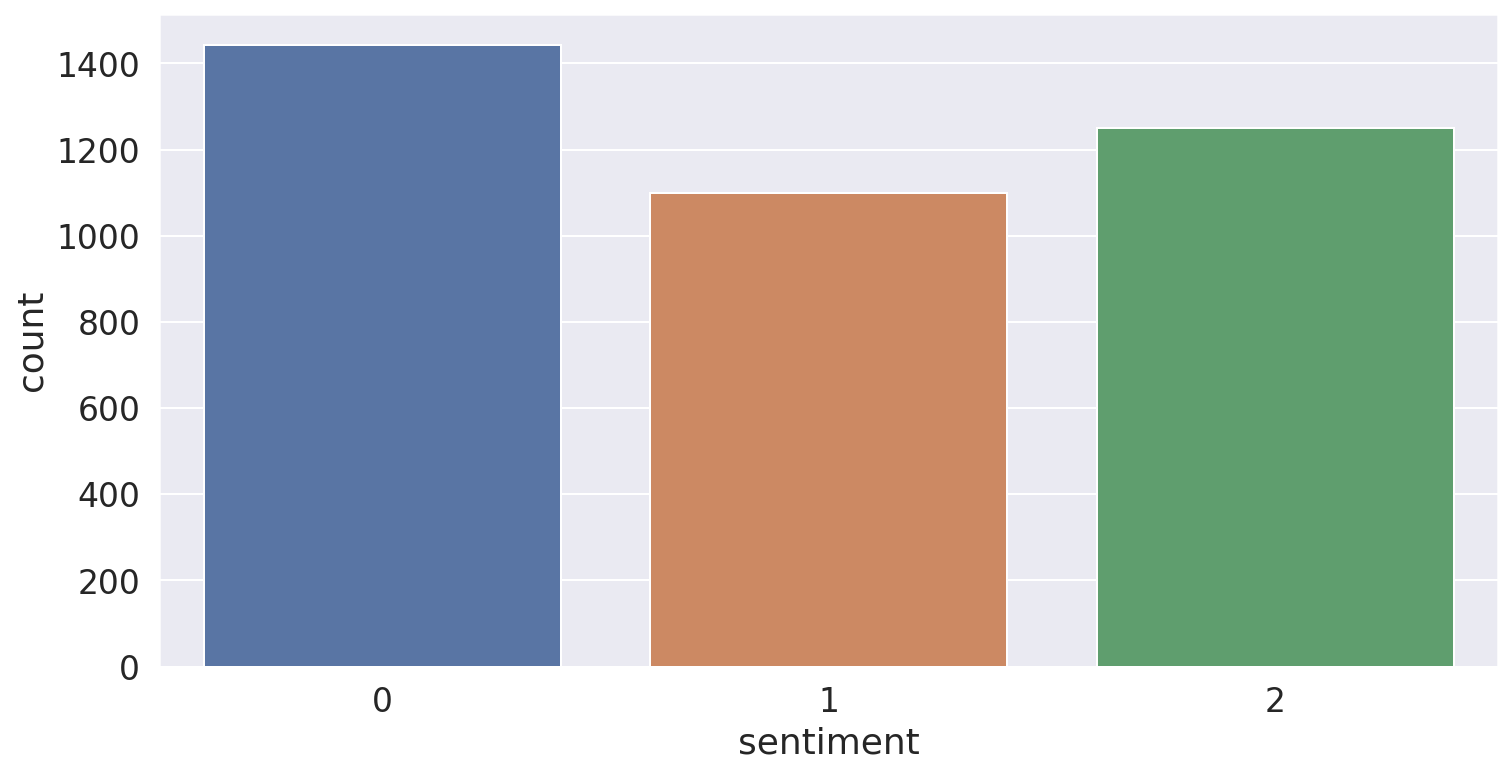

In [ ]:
sns.countplot('sentiment', data=df)

In [ ]:
tweet = df['tweet'].values
sentiment = df['sentiment'].values

In [ ]:
print (tokenizer.tokenize(tweet[0]))
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweet[0])))

['secara', 'pribadi', 'saya', 'mengakui', 'mayor', '##ita', 'mereka', 'pada', 'berfikir', 'realistis', '##bah', '##wa', 'vaksin', 'itu', 'sangat', 'perlu', 'karena', 'cov', '##id', 'ini', 'memang', 'mengancam', 'kehidupan', 'manusia', '##nah', 'kalau', 'di', 'masyarakat', 'yang', 'menolak', 'nggak', 'tahu', 'deh', 'alasannya', 'apa', '##set', '##ahu', 'saya', 'vaksin', 'itu', 'pelindung', '##co', '##vi', '##d', 'itu', 'pembunuh']
Token IDS:  [1789, 3960, 1731, 4516, 8918, 1636, 1633, 1560, 10990, 17215, 4041, 1630, 12959, 1570, 1906, 2506, 1686, 28912, 1528, 1540, 2362, 6538, 2730, 2112, 5299, 2280, 1485, 1956, 1497, 3381, 5940, 2818, 9969, 7911, 2064, 11795, 4413, 1731, 12959, 1570, 10243, 4322, 6952, 933, 1570, 11198]


In [ ]:
input_ids = []

for sent in tweet:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)
  
print("Original: ", tweet[0])
print("Token IDs: ", input_ids[0])


Original:  secara pribadi saya mengakui mayorita mereka pada berfikir realistisbahwa vaksin itu sangat perlu karena covid ini memang mengancam kehidupan manusianah kalau di masyarakat yang menolak nggak tahu deh alasannya apasetahu saya vaksin itu pelindungcovid itu pembunuh
Token IDs:  [3, 1789, 3960, 1731, 4516, 8918, 1636, 1633, 1560, 10990, 17215, 4041, 1630, 12959, 1570, 1906, 2506, 1686, 28912, 1528, 1540, 2362, 6538, 2730, 2112, 5299, 2280, 1485, 1956, 1497, 3381, 5940, 2818, 9969, 7911, 2064, 11795, 4413, 1731, 12959, 1570, 10243, 4322, 6952, 933, 1570, 11198, 4]


In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  72


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
input_ids[0]

array([    3,  1789,  3960,  1731,  4516,  8918,  1636,  1633,  1560,
       10990, 17215,  4041,  1630, 12959,  1570,  1906,  2506,  1686,
       28912,  1528,  1540,  2362,  6538,  2730,  2112,  5299,  2280,
        1485,  1956,  1497,  3381,  5940,  2818,  9969,  7911,  2064,
       11795,  4413,  1731, 12959,  1570, 10243,  4322,  6952,   933,
        1570, 11198,     4,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      sentiment,
                                                                      random_state=42,
                                                                      test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               sentiment,
                                               random_state=42,
                                               test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=42,
                                                                                  test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=42,
                                                     test_size=0.15)

In [ ]:
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (2901, 64)
Label:  (2901,)
Mask:  (2901, 64)

== Validation ==
Input:  (512, 64)
Label:  (512,)
Mask:  (512, 64)

== Test ==
Input:  (380, 64)
Label:  (380,)
Mask:  (380, 64)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 128
train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "indolem/indobert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (31923, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.e

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 1e-4,
    eps = 1e-8, weight_decay = 0.01
)

In [ ]:
model.config

BertConfig {
  "_name_or_path": "indolem/indobert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31923
}

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 25

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  total_eval_loss = 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_eval_loss += loss.item()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
  
  
  avg_val_loss = total_eval_loss / len(validation_dataloader)
  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'acc':eval_accuracy/nb_eval_steps
        }
    )
print("Training complete!")

======= Epoch 1 / 25 =======
Training...
   Average training loss: 1.03
   Training epoch took: 0:00:49
Running Validation...
   Accuracy: 0.65
   Validation took: 0:00:03
  Validation Loss: 0.90
======= Epoch 2 / 25 =======
Training...
   Average training loss: 0.80
   Training epoch took: 0:00:50
Running Validation...
   Accuracy: 0.61
   Validation took: 0:00:03
  Validation Loss: 0.83
======= Epoch 3 / 25 =======
Training...
   Average training loss: 0.63
   Training epoch took: 0:00:50
Running Validation...
   Accuracy: 0.71
   Validation took: 0:00:03
  Validation Loss: 0.84
======= Epoch 4 / 25 =======
Training...
   Average training loss: 0.43
   Training epoch took: 0:00:50
Running Validation...
   Accuracy: 0.72
   Validation took: 0:00:03
  Validation Loss: 0.32
======= Epoch 5 / 25 =======
Training...
   Average training loss: 0.35
   Training epoch took: 0:00:50
Running Validation...
   Accuracy: 0.73
   Validation took: 0:00:03
  Validation Loss: 0.36
======= Epoch 6 / 25

In [ ]:
# Display floats with three decimal places.
pd.set_option('precision', 3)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,acc
epoch,,,
1,1.031,0.902,0.648
2,0.804,0.829,0.609
3,0.626,0.837,0.709
4,0.433,0.325,0.725
5,0.349,0.364,0.732
6,0.244,0.159,0.730
7,0.218,0.283,0.725
8,0.182,0.341,0.748
9,0.182,0.205,0.730


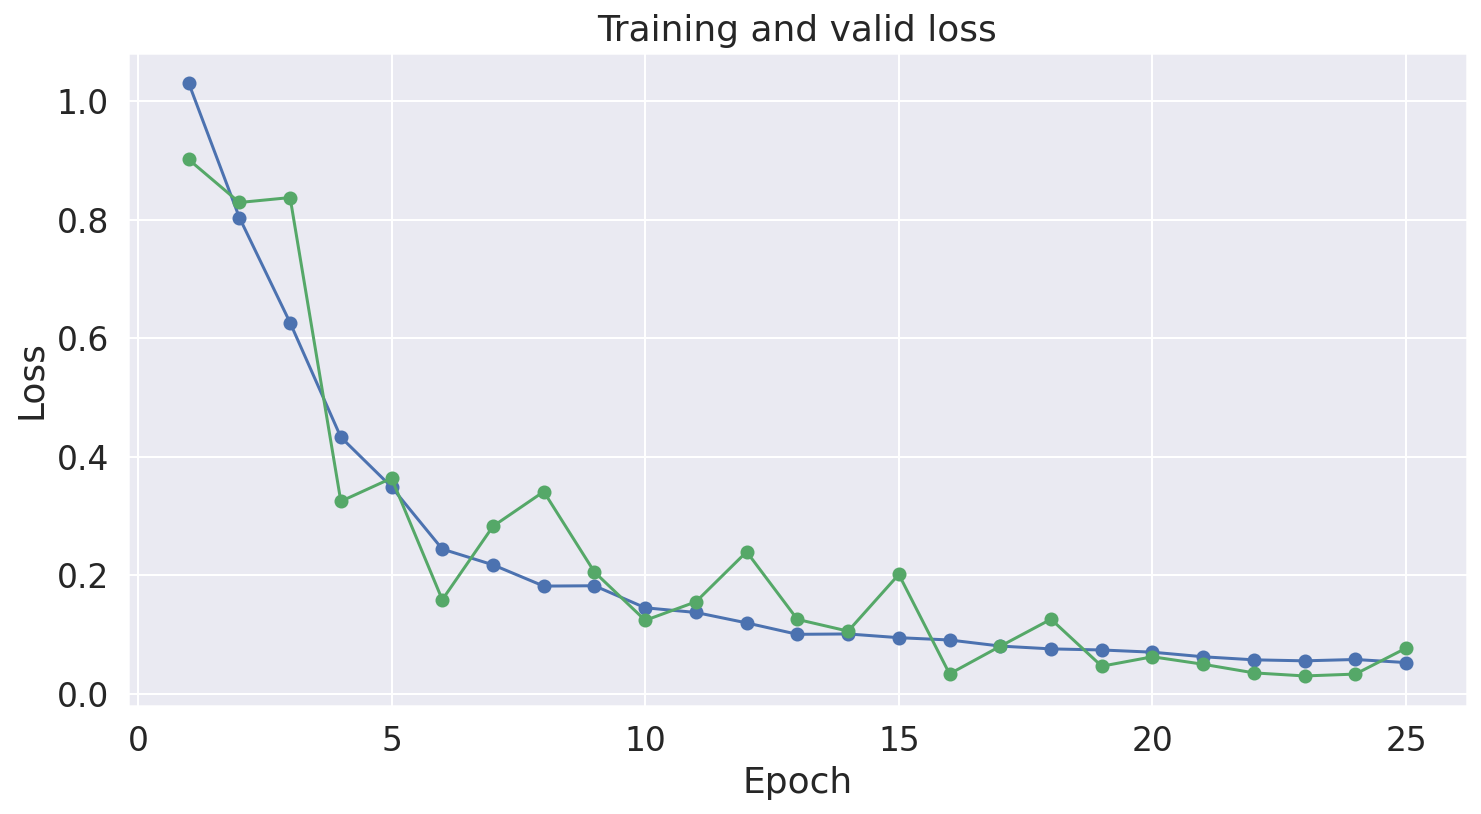

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training and valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    
  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

In [ ]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.540


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.697


In [ ]:
train_acc = df_stats['acc'].mean()
train_loss = df_stats['Training Loss'].mean()
val_loss = df_stats['Valid. Loss'].mean()


In [ ]:
train_loss

0.21770750197217514

In [ ]:
val_loss

0.2307726974785328

In [ ]:
train_acc

0.715625

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
print('Recall: {}'.format(recall_score(flat_true_labels, flat_prediction,average='weighted')))
print('Precision: {}'.format(precision_score(flat_true_labels, flat_prediction,average='weighted')))
print('F1-Score: {}'.format(f1_score(flat_true_labels, flat_prediction,average='weighted')))

Recall: 0.6973684210526315
Precision: 0.6983648871484132
F1-Score: 0.697069101974537


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(confusion_matrix(flat_true_labels, flat_prediction))

[[ 93  28  25]
 [ 19  61  11]
 [ 22  10 111]]


In [ ]:
print(classification_report(flat_true_labels, flat_prediction))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       146
           1       0.62      0.67      0.64        91
           2       0.76      0.78      0.77       143

    accuracy                           0.70       380
   macro avg       0.69      0.69      0.69       380
weighted avg       0.70      0.70      0.70       380

